In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op

In [2]:
# Load Data
data = np.loadtxt('ex2data1.txt', delimiter=',')
X = data[:, 0:2]
y = data[:, 2, np.newaxis]

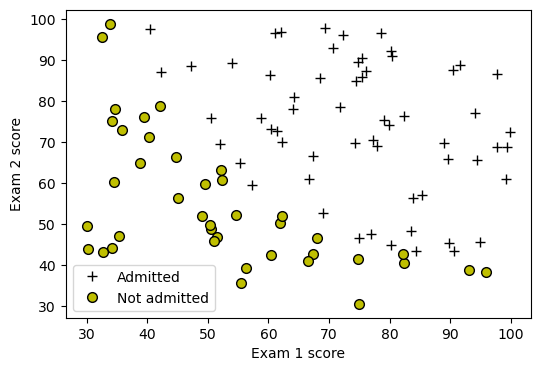

In [3]:
pos = X[(y == 1).repeat(1)]
neg = X[(y == 0).repeat(1)]

fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(pos[:, 0], pos[:, 1], 'k+', linewidth=2, markersize=7)
ax1.plot(neg[:, 0], neg[:, 1], 'ko', markerfacecolor='y', markersize=7)

ax1.set_xlabel('Exam 1 score')
ax1.set_ylabel('Exam 2 score')

ax1.legend(['Admitted', 'Not admitted'])

In [4]:
def sigmoid(z):
	g = 1 / (1 + np.exp(-z))
	return g

In [5]:
sigmoid(0)

0.5

In [6]:
def costFunction(theta, X, y):
	theta = theta.reshape(-1, 1)  # 使用库函数优化会传入(n, )array，为了运算统一转化为(n, 1)array
	m = y.size
	# J = np.sum(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta))) / m
	J = (-y.T @ np.log(sigmoid(X @ theta)) - (1 - y).T @ np.log(1 - sigmoid(X @ theta))) / m
	# grad = np.sum((sigmoid(X @ theta) - y) * X, axis=0) / m       # 根据矩阵乘法优化
	grad = X.T @ (sigmoid(X @ theta) - y) / m
	return J[0, 0], grad

In [7]:
m, n = X.shape

X = np.concatenate((np.ones((m, 1)), X), axis=1)

initial_theta = np.zeros((n + 1, 1))

In [8]:
cost, grad = costFunction(initial_theta, X, y)
print('Cost at initial theta (zeros): {:f}\n'.format(cost))

Cost at initial theta (zeros): 0.693147



In [9]:
print('Gradient at initial theta (zeros):\n{}'.format(grad))

Gradient at initial theta (zeros):
[[ -0.1       ]
 [-12.00921659]
 [-11.26284221]]


In [10]:
test_theta = np.array([[-24], [0.2], [0.2]])
cost, grad = costFunction(test_theta, X, y)
print('Cost at non-zero test theta: {:f}'.format(cost))

Cost at non-zero test theta: 0.218330


In [11]:
print('Gradient at non-zero theta:\n{}\n'.format(grad))

Gradient at non-zero theta:
[[0.04290299]
 [2.56623412]
 [2.64679737]]



In [12]:
# initial_theta = np.zeros(3)       # theta被传入后,会被转换为(n, )array，不需要手动变化
res = op.fmin_tnc(func=costFunction, x0=initial_theta, args=(X, y))
print(res)

(array([-25.16131857,   0.20623159,   0.20147149]), 36, 0)


In [13]:
# 使用minimize，损失函数和梯度下降函数分开实现
def costFunction(theta, X, y):
	# theta = theta.reshape(-1, 1)
	m = y.size
	# J = np.sum(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta))) / m	# 根据矩阵乘法优化
	y = y.flatten()
	J = (-y.T @ np.log(sigmoid(X @ theta)) - (1 - y).T @ np.log(1 - sigmoid(X @ theta))) / m
	return J


def gradient(theta, X, y):
	theta = theta.reshape(-1, 1)
	m = y.size
	grad = X.T @ (sigmoid(X @ theta) - y) / m
	return grad


initial_theta = np.zeros(n + 1)
res = op.minimize(fun=costFunction, x0=initial_theta, args=(X, y), method='TNC', jac=gradient)
print(res)

     fun: 0.20349770158947464
     jac: array([[9.56475235e-09],
       [1.37863724e-07],
       [4.94652395e-07]])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 36
     nit: 17
  status: 0
 success: True
       x: array([-25.16131857,   0.20623159,   0.20147149])


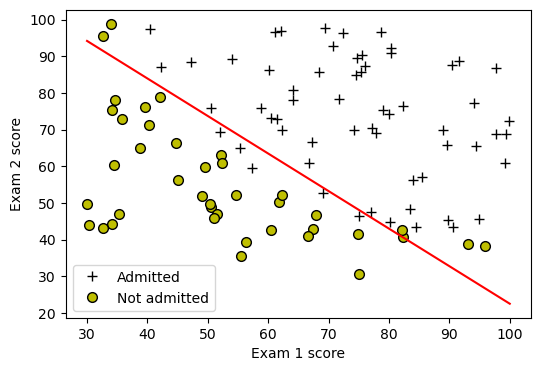

In [14]:
boundary_x = np.linspace(30, 100, 100)
# 决策边界 theta.T @ X = 0
theta = res.x
boundary_y = (- theta[0] - theta[1] * boundary_x) / theta[2]
ax1.plot(boundary_x, boundary_y, 'r')

ax1.get_legend().remove()
ax1.legend(['Admitted', 'Not admitted'])
fig1

In [15]:
prob = sigmoid(np.array([1, 45, 85]) @ theta)
print('For a student with scores 45 and 85, we predict an admission probability of {:f}'.format(prob))

For a student with scores 45 and 85, we predict an admission probability of 0.776291


In [16]:
def predict(theta, X):
	p = sigmoid(X @ theta.reshape(-1, 1))
	p[p >= 0.5] = 1
	p[p < 0.5] = 0
	return p

In [17]:
p = predict(theta, X)
print('Train Accuracy: {:.1f}%'.format(np.mean(p == y) * 100))

Train Accuracy: 89.0%


In [18]:
data = np.loadtxt('ex2data2.txt', delimiter=',')
X = data[:, 0:2]
y = data[:, 2, np.newaxis]

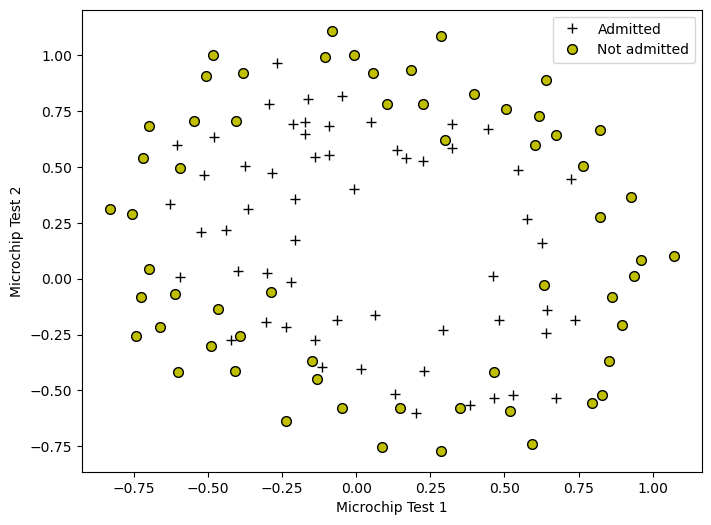

In [19]:
pos = X[(y == 1).repeat(1)]
neg = X[(y == 0).repeat(1)]

fig2, ax2 = plt.subplots(figsize=(8, 6))

ax2.plot(pos[:, 0], pos[:, 1], 'k+', linewidth=2, markersize=7)
ax2.plot(neg[:, 0], neg[:, 1], 'ko', markerfacecolor='y', markersize=7)


ax2.set_xlabel('Microchip Test 1')
ax2.set_ylabel('Microchip Test 2')

ax2.legend(['Admitted', 'Not admitted'])

In [20]:
def mapFeature(X1, X2):
	degree = 6
	out = np.ones(X1.shape)

	for i in range(1, degree + 1):
		for j in range(i + 1):
			out = np.append(out, np.power(X1, (i - j)) * np.power(X2, j), axis=1)
	return out

In [21]:
X = mapFeature(X[:, 0, np.newaxis], X[:, 1, np.newaxis])

In [22]:
def costFunctionReg(theta, X, y, lambda_opt):
	# theta = theta.reshape(-1, 1)
	j = theta.shape[0]
	y = y.flatten()
	m = y.shape[0]

	# J = np.sum(
	# 	-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta))) / m + lambda_opt / 2 / m * np.sum(
	# 	np.power(theta[1:, :], 2))			# 根据矩阵乘法优化
	J = (-y.T @ np.log(sigmoid(X @ theta)) - (1 - y).T @ np.log(
		1 - sigmoid(X @ theta))) / m + lambda_opt / 2 / m * theta[1:].T @ theta[1:]

	grad = np.zeros(j)
	# grad[0] = np.sum((sigmoid(X @ theta) - y) * X[:, 0, np.newaxis]) / m		# 根据矩阵乘法优化
	grad[0] = ((sigmoid(X @ theta) - y) @ X[:, 0]) / m
	for i in range(1, j):
		# grad[i] = np.sum((sigmoid(X @ theta) - y) * X[:, i, np.newaxis]) / m + lambda_opt / m * theta[i, 0]		# 根据矩阵乘法优化
		grad[i] = ((sigmoid(X @ theta) - y) @ X[:, i]) / m + lambda_opt / m * theta[i]
	return J, grad

In [23]:
initial_theta = np.zeros((X.shape[1]))

lambda_opt = 0

cost, grad = costFunctionReg(initial_theta, X, y, lambda_opt)
print('Cost at initial theta (zeros): {:f}'.format(cost))

Cost at initial theta (zeros): 0.693147


In [24]:
print('Gradient at initial theta (zeros) - first five values only:\n{}'.format(grad[:5].reshape(-1, 1)))

Gradient at initial theta (zeros) - first five values only:
[[8.47457627e-03]
 [1.87880932e-02]
 [7.77711864e-05]
 [5.03446395e-02]
 [1.15013308e-02]]


In [25]:
test_theta = np.ones(X.shape[1])

cost, grad = costFunctionReg(test_theta, X, y, 10)
print('Cost at test theta (with lambda = 10): {:f}'.format(cost))

Cost at test theta (with lambda = 10): 3.164509


In [26]:
print('Gradient at test theta - first five values only:\n{}'.format(grad[:5].reshape(-1, 1)))

Gradient at test theta - first five values only:
[[0.34604507]
 [0.16135192]
 [0.19479576]
 [0.22686278]
 [0.09218568]]


In [27]:
# tnc方法实现
# lambda_opt = 1
# res = op.fmin_tnc(func=costFunctionReg, x0=initial_theta, args=(X, y, lambda_opt))
# theta = res[0]
# print(res)

In [28]:
# 使用minimize，BFGS方法，损失函数和梯度下降函数分开实现
def costFunctionReg(theta, X, y, lambda_opt):
	theta = theta.reshape(-1, 1)
	j = theta.shape[0]
	m = y.shape[0]

	J = np.sum(
		-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta))) / m + lambda_opt / 2 / m * np.sum(
		np.power(theta[1:, :], 2))
	return J


def gradientReg(theta, X, y, lambda_opt):
	theta = theta.reshape(-1, 1)
	j = theta.shape[0]
	m = y.shape[0]

	grad = np.zeros(j)
	grad[0] = np.sum((sigmoid(X @ theta) - y) * X[:, 0, np.newaxis]) / m
	for i in range(1, j):
		grad[i] = np.sum((sigmoid(X @ theta) - y) * X[:, i, np.newaxis]) / m + lambda_opt / m * theta[i, 0]
	return grad


lambda_opt = 0
initial_theta = np.zeros((X.shape[1]))
res = op.minimize(fun=costFunctionReg, x0=initial_theta, args=(X, y, lambda_opt), method='BFGS', jac=gradientReg)
theta = res.x
print(res)

      fun: 0.224568732299272
 hess_inv: array([[ 1.85826245e+04,  2.25262060e+04,  3.73224646e+04,
        -1.78814079e+05, -9.42019960e+04, -9.81991227e+04,
        -1.43908985e+05, -3.09558745e+05, -2.47561181e+05,
        -1.69371470e+05,  5.35610185e+05,  5.98947544e+05,
         8.60485899e+05,  4.18076177e+05,  2.21162111e+05,
         2.19369736e+05,  5.61249921e+05,  7.88872682e+05,
         8.61845666e+05,  5.02983008e+05,  2.16414357e+05,
        -5.18285882e+05, -9.00819359e+05, -1.59855764e+06,
        -1.55217990e+06, -1.40628719e+06, -6.49242851e+05,
        -2.29700236e+05],
       [ 2.25262060e+04,  3.71696511e+04,  3.53556855e+04,
        -2.21856037e+05, -1.11666127e+05, -1.23477224e+05,
        -2.44080604e+05, -3.66318594e+05, -2.82030044e+05,
        -1.41381144e+05,  7.01758460e+05,  7.40727026e+05,
         1.06048150e+06,  4.92367782e+05,  2.56758506e+05,
         3.79927612e+05,  7.76153479e+05,  1.00417289e+06,
         8.58495545e+05,  4.34256702e+05,  1.4609

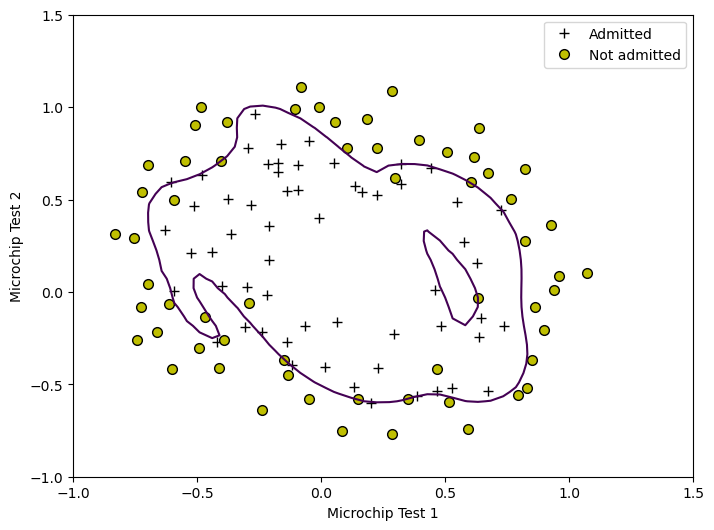

In [29]:
boundary_u = np.mat(np.linspace(-1, 1.5, 50)).reshape(-1, 1)
boundary_v = np.mat(np.linspace(-1, 1.5, 50)).reshape(-1, 1)

z = np.zeros((len(boundary_u), len(boundary_v)))


def mapFeature(X1, X2):
	degree = 6
	out = np.ones(X1.shape)
	for i in range(1, degree + 1):
		for j in range(i + 1):
			out = np.append(out, np.power(X1, (i - j)) * np.power(X2, j), axis=1)
	return out


for i in range(len(boundary_u)):
	for j in range(len(boundary_v)):
		z[i, j] = (mapFeature(boundary_u[i], boundary_v[j]) @ theta)

u, v = np.meshgrid(boundary_u, boundary_v)
ax2.contour(u, v, z.T, levels=[0])
fig2

In [30]:
p = predict(theta, X)
print('Train Accuracy: {:f}'.format(np.mean(p == y) * 100))

Train Accuracy: 91.525424
